# Travel Package Prediction Analysis
This notebook analyzes the Travel dataset to build classification models for 'ProdTaken'.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

%matplotlib inline


In [2]:
# Load the dataset
# Ensure 'Travel.csv' is in the same directory
df = pd.read_csv('Travel.csv')

# Inspect the initial rows and data info
print("First 5 rows:")
display(df.head())
print("\nData Info:")
print(df.info())


First 5 rows:


,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 

In [3]:
# --- Data Cleaning ---

# Drop identifier column
df_clean = df.drop(columns=['CustomerID'])

# Impute Missing Values
# Numerical columns: Median imputation
num_cols_with_na = ['Age', 'DurationOfPitch', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'NumberOfChildrenVisiting', 'MonthlyIncome']
for col in num_cols_with_na:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Categorical columns: Mode imputation
cat_cols_with_na = ['TypeofContact']
for col in cat_cols_with_na:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

# Fix inconsistencies in categorical data
df_clean['Gender'] = df_clean['Gender'].replace('Fe Male', 'Female')
df_clean['MaritalStatus'] = df_clean['MaritalStatus'].replace('Single', 'Unmarried')

print("Missing values after cleaning:")
print(df_clean.isnull().sum().sum())


Missing values after cleaning:
0


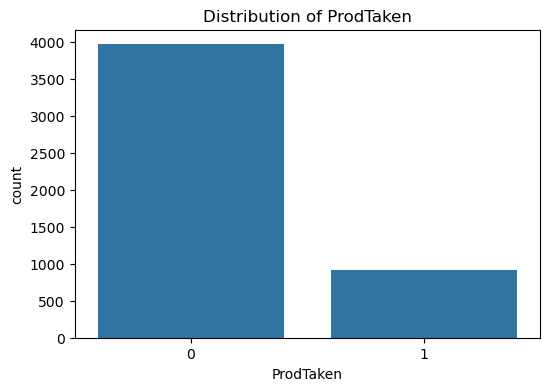

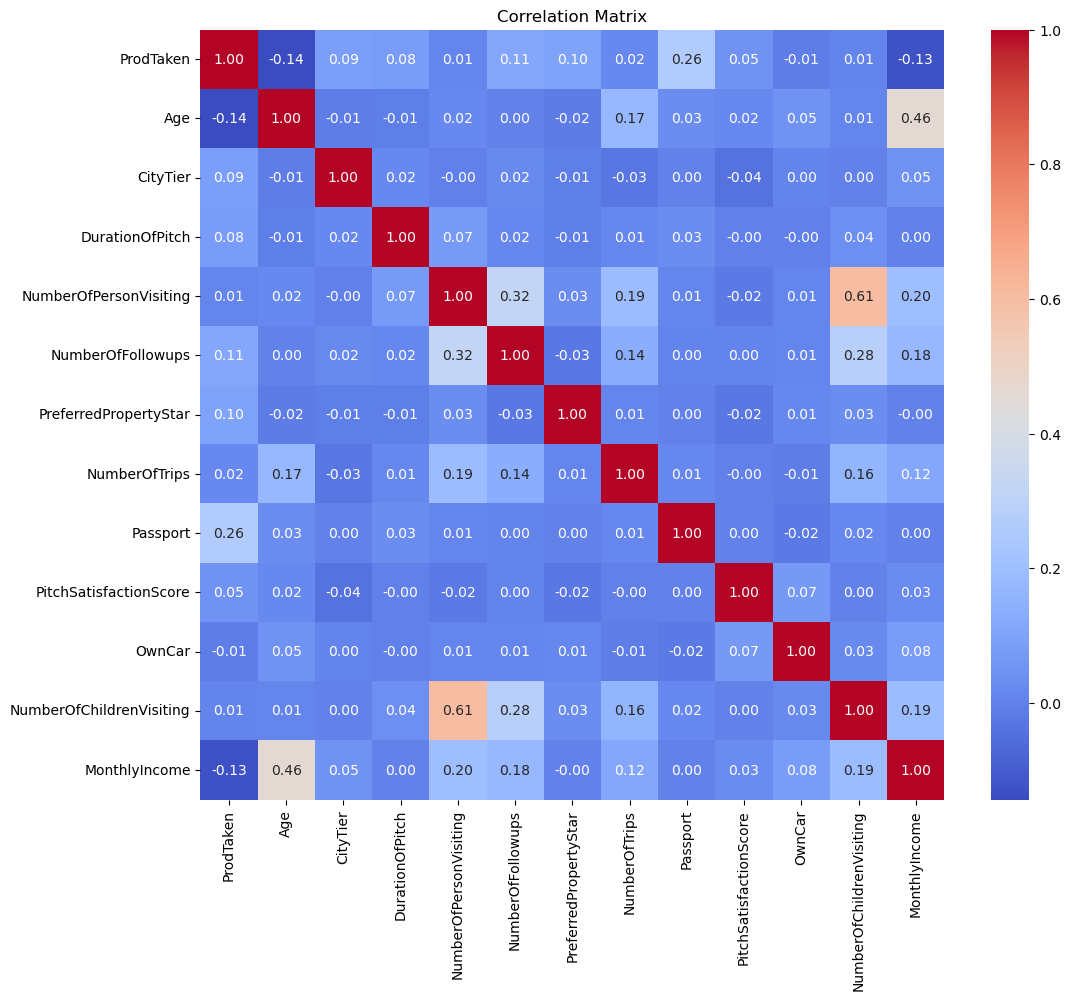

In [4]:
# --- Exploratory Data Analysis ---

# 1. Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='ProdTaken', data=df_clean)
plt.title('Distribution of ProdTaken')
plt.show()

# 2. Correlation Matrix
# Select numeric columns
numeric_df = df_clean.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [5]:
# --- Preprocessing ---

# One-Hot Encoding for categorical variables
categorical_cols = ['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation']
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# Separate Features (X) and Target (y)
X = df_encoded.drop('ProdTaken', axis=1)
y = df_encoded['ProdTaken']

# Train-Test Split (80% Train, 20% Test)
# Stratify ensures the class balance is preserved in the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (3910, 27)
Test set shape: (978, 27)


In [6]:
# --- Model Development ---

# 1. Decision Tree Classifier
dt_params = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_
print("Best Decision Tree Params:", dt_grid.best_params_)

# 2. Random Forest Classifier
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'bootstrap': [True]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
print("Best Random Forest Params:", rf_grid.best_params_)


Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}
Best Random Forest Params: {'bootstrap': True, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}



--- Decision Tree ---
Accuracy: 0.9049079754601227
ROC AUC: 0.8412276859051583
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       794
           1       0.75      0.74      0.75       184

    accuracy                           0.90       978
   macro avg       0.85      0.84      0.84       978
weighted avg       0.90      0.90      0.90       978



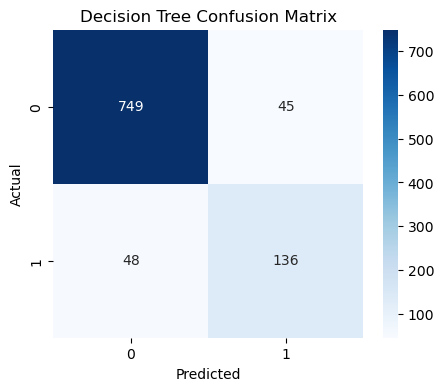


--- Random Forest ---
Accuracy: 0.9233128834355828
ROC AUC: 0.9559193954659951
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       794
           1       0.95      0.62      0.75       184

    accuracy                           0.92       978
   macro avg       0.93      0.81      0.85       978
weighted avg       0.93      0.92      0.92       978



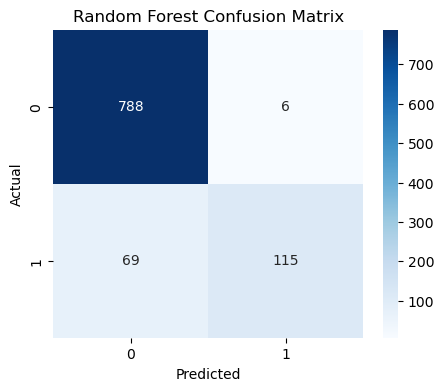

In [7]:
# --- Model Evaluation ---

def evaluate_and_plot(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"\n--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return y_prob

# Evaluate Decision Tree
y_prob_dt = evaluate_and_plot(dt_best, X_test, y_test, "Decision Tree")

# Evaluate Random Forest
y_prob_rf = evaluate_and_plot(rf_best, X_test, y_test, "Random Forest")


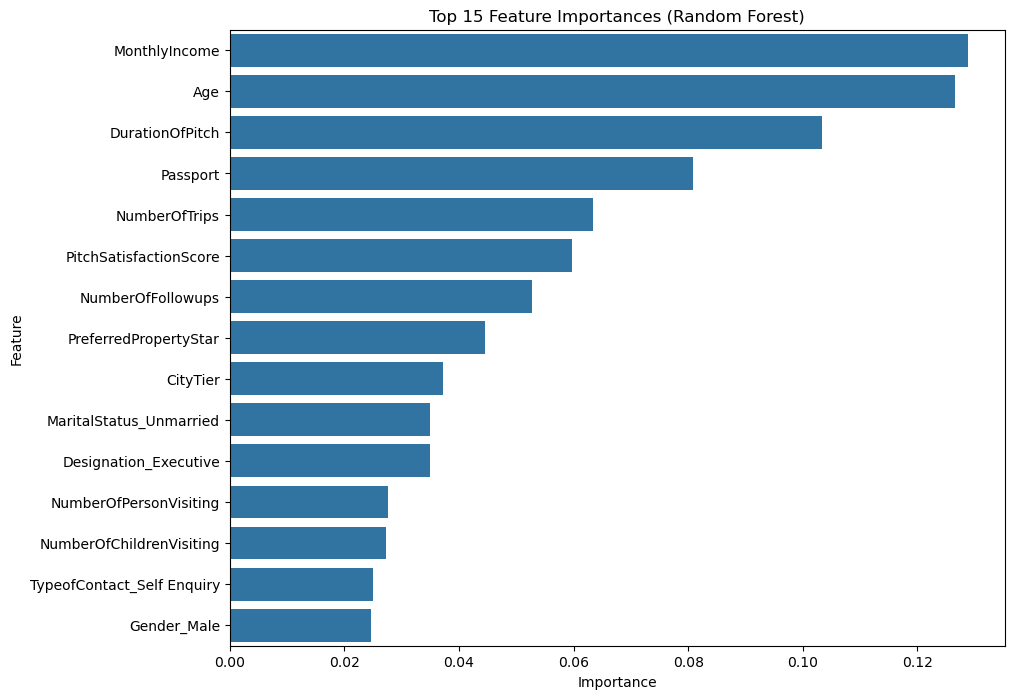

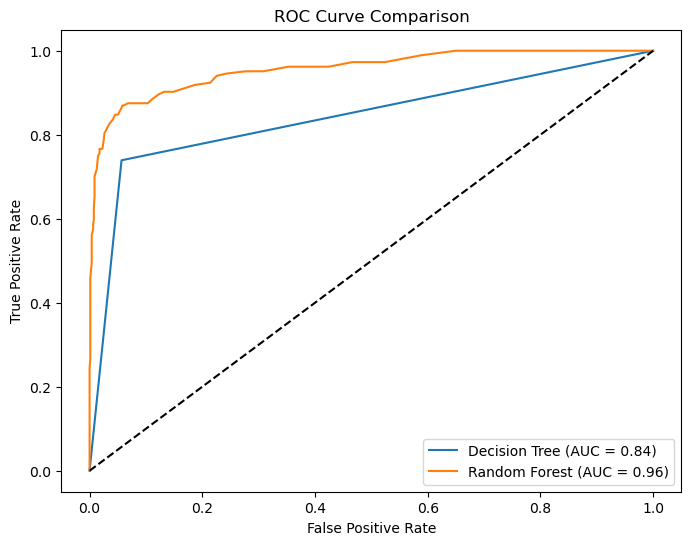

In [8]:
# --- Visualization ---

# 1. Feature Importance (Random Forest)
importances = rf_best.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()

# 2. ROC Curve Comparison
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_score(y_test, y_prob_dt):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()
